In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv(r"C:\Users\Dar Computers\Desktop\10Acadamy\week 3\code\acis-week3-insurance-analysis\data\processed\insurance_cleanedd.csv")


In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# ============================
# 2. Drop useless or constant columns
# ============================
columns_to_drop = [
    "PolicyID", "Country", "Language",
    "StatutoryClass", "StatutoryRiskType", "ItemType","TransactionMonth","VehicleIntroDate"
]
df.drop(columns=columns_to_drop, inplace=True)

# ============================
# 3. Label encode high-cardinality features
# ============================
label_encode_cols = ["PostalCode", "Bank"]
label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # optional: keep for later inverse_transform

# ============================
# 4. One-hot encode low-cardinality categoricals
# ============================
low_cardinality_cols = [
    "Gender", "VehicleType", "Title", "AccountType", "Section", "Product",
    "LegalType", "NewVehicle", "MaritalStatus", "bodytype",
    "NumberOfDoors", "Cylinders", "ExcessSelected", "Province",
    "TrackingDevice", "AlarmImmobiliser", "IsVATRegistered",
    "TermFrequency"
]
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# ============================
# 5. Filter for severity modeling
# ============================
df_severity = df[df["TotalClaims"] > 0].copy()

# ============================
# 6. Handle missing values
# ============================
df_severity.fillna(0, inplace=True)

# ============================
# 7. Define X and y
# ============================
X = df_severity.drop(columns=["TotalClaims"])
y = df_severity["TotalClaims"]

# OPTIONAL: log-transform target if needed
# y = np.log1p(y)

# ============================
# 8. Train-test split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data ready for severity modeling!")
print("🔢 X_train shape:", X_train.shape)
print("🎯 y_train sample:", y_train.head())


✅ Data ready for severity modeling!
🔢 X_train shape: (2220, 96)
🎯 y_train sample: 95321        750.649123
193955      1315.789474
654241     60549.473684
565430      1400.000000
848435    111866.368421
Name: TotalClaims, dtype: float64


In [81]:
#  Safely convert all object columns to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Replace NaNs introduced by invalid conversions
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Now all values are guaranteed to be numeric


In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear_Regression": LinearRegression(),
    "Random_Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R^2": r2}


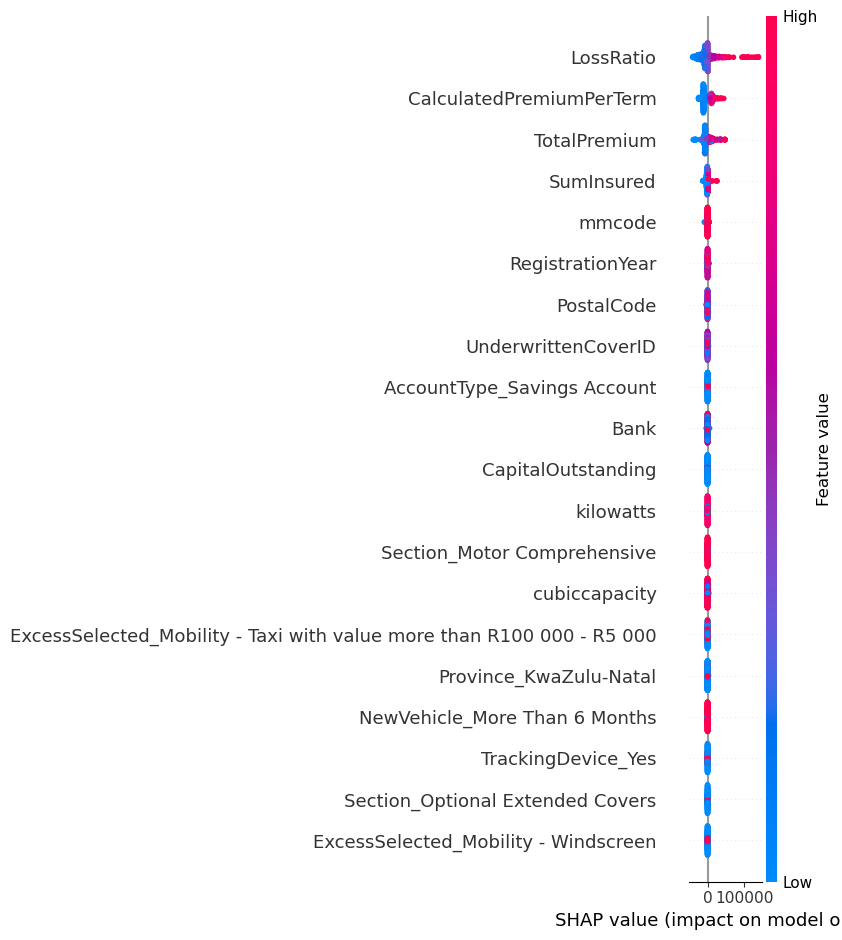

In [93]:
import shap

# Explicitly ensure float64
X_train_shap = X_train.astype('float64')
X_test_shap = X_test.astype('float64')

# Run SHAP
best_model = models["XGBoost"]
explainer = shap.Explainer(best_model, X_train_shap)
shap_values = explainer(X_test_shap)

# Plot
shap.summary_plot(shap_values, X_test_shap)


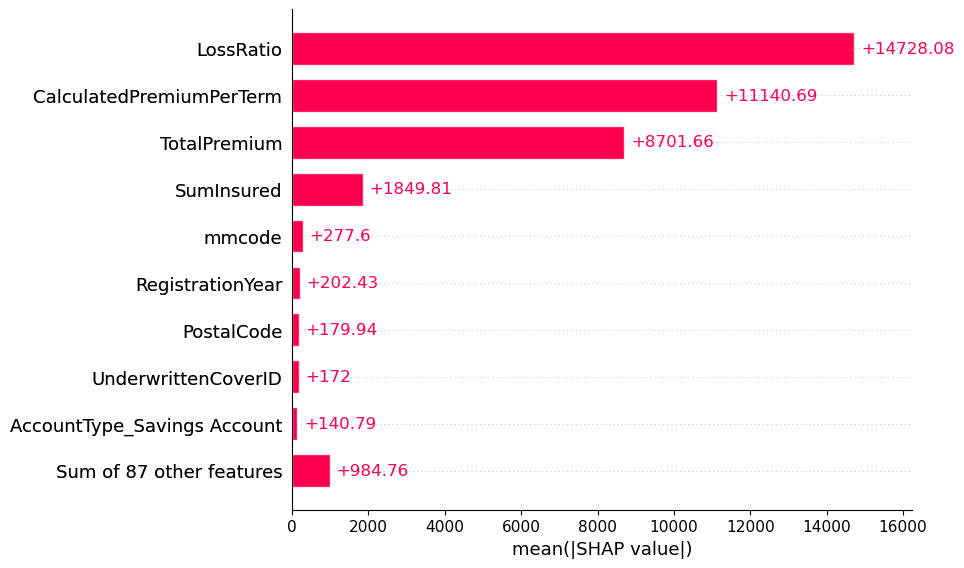

In [97]:
shap.plots.bar(shap_values)


In [103]:
# === 1. Classification Model: Predict Probability of a Claim ===
df["HasClaim"] = (df["TotalClaims"] > 0).astype(int)

X_cls = df.drop(columns=["TotalClaims", "HasClaim"])
y_cls = df["HasClaim"]

# Ensure numeric
X_cls = X_cls.apply(pd.to_numeric, errors='coerce')
X_cls.fillna(0, inplace=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

print("📊 Classification Metrics:")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall:", recall_score(y_test_cls, y_pred_cls))
print("F1 Score:", f1_score(y_test_cls, y_pred_cls))


📊 Classification Metrics:
Accuracy: 0.9998749330892027
Precision: 0.9980694980694981
Recall: 0.955637707948244
F1 Score: 0.9763928234183191


In [109]:
# === 2. Naive Premium Prediction Model ===
from sklearn.metrics import root_mean_squared_error
X_premium = df.drop(columns=["CalculatedPremiumPerTerm"])
y_premium = df["CalculatedPremiumPerTerm"]

# Ensure numeric
X_premium = X_premium.apply(pd.to_numeric, errors='coerce')
X_premium.fillna(0, inplace=True)

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train_prem, X_test_prem, y_train_prem, y_test_prem = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)

model_premium = XGBRegressor(random_state=42)
model_premium.fit(X_train_prem, y_train_prem)
y_pred_prem = model_premium.predict(X_test_prem)
rmse = root_mean_squared_error(y_test_prem, y_pred_prem)

print("💰 Premium Prediction Metrics:")
print("RMSE:", rmse)
print("R^2:", r2_score(y_test_prem, y_pred_prem))


💰 Premium Prediction Metrics:
RMSE: 21.738870701905128
R^2: 0.9903541785054302


In [119]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Access models from your dictionary
linear_model = models["Linear_Regression"]
rf_model = models["Random_Forest"]
xgb_model = models["XGBoost"]

# Linear Regression
rmse_linear = root_mean_squared_error(y_test, linear_model.predict(X_test))
r2_linear = r2_score(y_test, linear_model.predict(X_test))

# Random Forest
rmse_rf = root_mean_squared_error(y_test, rf_model.predict(X_test))
r2_rf = r2_score(y_test, rf_model.predict(X_test))

# XGBoost
rmse_xgb = root_mean_squared_error(y_test, xgb_model.predict(X_test))
r2_xgb = r2_score(y_test, xgb_model.predict(X_test))


In [123]:
# === 3. Model Comparison Table ===
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse_linear, rmse_rf, rmse_xgb],  # replace with your actual values
    "R^2": [r2_linear, r2_rf, r2_xgb]
})
print("\n📊 Model Comparison Table")
print(comparison_df)



📊 Model Comparison Table
               Model          RMSE       R^2
0  Linear Regression  42029.915100 -0.240423
1      Random Forest   6725.675197  0.968237
2            XGBoost   7481.251289  0.960699


 95%|=================== | 529/555 [00:13<00:00]       

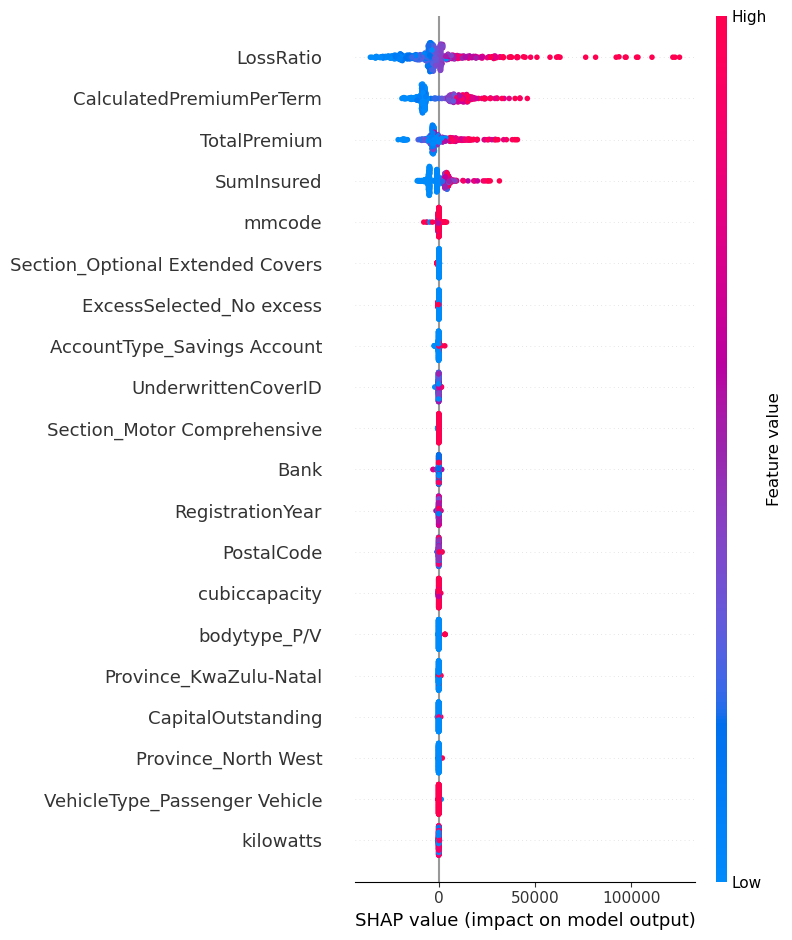

In [125]:
import shap

X_shap = X_test.astype("float64")
best_model = rf_model  # or xgb_model

explainer = shap.Explainer(best_model, X_shap)
shap_values = explainer(X_shap)

shap.summary_plot(shap_values, X_shap)


In [127]:
# === 4. Business Interpretation Comment (Markdown/Print) ===
print("""
🧠 SHAP Interpretation Summary:

- 'LossRatio' has the highest influence on predicted claim severity. As it increases, the model predicts higher claim costs, indicating riskier profiles.
- 'CalculatedPremiumPerTerm' and 'TotalPremium' also have strong impact—suggesting premium-setting and exposure level affect claims.
- Insight: Policies with high LossRatio and low premium may be underpriced, creating a margin risk.

📈 Action: Refine premium pricing by adjusting for high-risk segments based on LossRatio, Premium, and SumInsured SHAP contributions.
""")



🧠 SHAP Interpretation Summary:

- 'LossRatio' has the highest influence on predicted claim severity. As it increases, the model predicts higher claim costs, indicating riskier profiles.
- 'CalculatedPremiumPerTerm' and 'TotalPremium' also have strong impact—suggesting premium-setting and exposure level affect claims.
- Insight: Policies with high LossRatio and low premium may be underpriced, creating a margin risk.

📈 Action: Refine premium pricing by adjusting for high-risk segments based on LossRatio, Premium, and SumInsured SHAP contributions.

